In [1]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import transforms
import medmnist
from medmnist import INFO

In [2]:
data_flag = "retinamnist"
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()
])

# load the data
_train_dataset = DataClass(split='train', transform=data_transform, download=download, root="../data/")
_valid_dataset = DataClass(split='val', transform=data_transform, download=download, root="../data/")
_test_dataset = DataClass(split='test', transform=data_transform, download=download, root="../data/")

dataset = ConcatDataset([_train_dataset, _valid_dataset, _test_dataset])

BATCH_SIZE = 128

train, test = torch.utils.data.random_split(dataset, [len(_train_dataset) + len(_valid_dataset), len(_test_dataset)])
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz
Using downloaded and verified file: ../data/retinamnist.npz


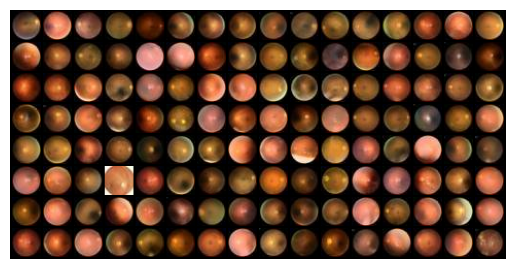

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

img_batch, _ = next(iter(train_loader))
plt.imshow(make_grid(img_batch, nrow=16).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
from src.model import VAE, SimpleCNNClassifier
from src.trainer import CDVAETrainer, SimpleCNNTrainer
from src.model import interpolate_latent

%load_ext autoreload
%autoreload 2

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [8]:
cnn = SimpleCNNClassifier(n_class=5, in_channel=3).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 20, device, transform)

In [9]:
trainer.fit(101, train_loader, test_loader)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 125.00it/s]


val_aupr: {0: 0.714, 1: 0.103, 2: 0.248, 3: 0.225, 4: 0.111}
0.28
val_auroc: {0: 0.74, 1: 0.516, 2: 0.611, 3: 0.58, 4: 0.612}
0.612


val-epoch 20: 100%|██████████| 4/4 [00:00<00:00, 181.76it/s]


val_aupr: {0: 0.849, 1: 0.172, 2: 0.308, 3: 0.429, 4: 0.133}
0.378
val_auroc: {0: 0.825, 1: 0.694, 2: 0.686, 3: 0.804, 4: 0.687}
0.739


val-epoch 40: 100%|██████████| 4/4 [00:00<00:00, 173.91it/s]


val_aupr: {0: 0.853, 1: 0.154, 2: 0.324, 3: 0.429, 4: 0.11}
0.374
val_auroc: {0: 0.825, 1: 0.674, 2: 0.694, 3: 0.802, 4: 0.675}
0.734


val-epoch 60: 100%|██████████| 4/4 [00:00<00:00, 166.67it/s]


val_aupr: {0: 0.854, 1: 0.168, 2: 0.32, 3: 0.433, 4: 0.123}
0.38
val_auroc: {0: 0.826, 1: 0.694, 2: 0.695, 3: 0.805, 4: 0.695}
0.743


val-epoch 80: 100%|██████████| 4/4 [00:00<00:00, 144.61it/s]


val_aupr: {0: 0.855, 1: 0.166, 2: 0.328, 3: 0.44, 4: 0.119}
0.382
val_auroc: {0: 0.83, 1: 0.697, 2: 0.701, 3: 0.806, 4: 0.69}
0.745


val-epoch 100: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s]

val_aupr: {0: 0.859, 1: 0.163, 2: 0.335, 3: 0.457, 4: 0.111}
0.385
val_auroc: {0: 0.834, 1: 0.682, 2: 0.701, 3: 0.801, 4: 0.68}
0.74


In [10]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 156.66it/s]

val_aupr: {0: 0.859, 1: 0.163, 2: 0.335, 3: 0.457, 4: 0.111}
0.385
val_auroc: {0: 0.834, 1: 0.682, 2: 0.701, 3: 0.801, 4: 0.68}
0.74


In [11]:
from sklearn.manifold import TSNE

In [52]:
hs = []
labels = []
with torch.no_grad():
    for X, label in tqdm(train_loader):
        X = X.to(device)
        label = label.to(device)

        h = cnn.net(X)
        hs.append(h)
        labels.append(label)

hs = torch.cat(hs, dim=0)
labels = torch.cat(labels, dim=0)


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
hs_tsne = tsne.fit_transform(hs.cpu().numpy())

100%|██████████| 10/10 [00:00<00:00, 129.23it/s]


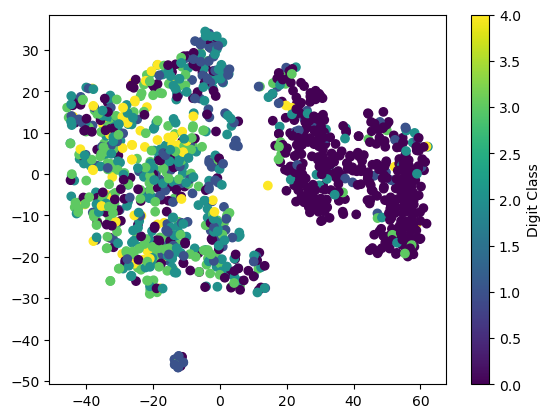

In [53]:
plt.scatter(hs_tsne[:, 0], hs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [50]:
Z_DIM = 32
TEMP = 0.2
ALPHA = [100, 100]
LABEL_FLIPPING = True
vae = VAE(total_z_dim=Z_DIM, in_channel=3).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-4, weight_decay=1e-2)
trainer = CDVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=30,
    device=device,
    transform=transform
)

In [51]:
trainer.fit(421, train_loader, test_loader)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 97.49it/s]


val_recontr_loss=269.771, val_kl_c=0.005, val_kl_s=0.011, val_c_loss=1.328, val_s_loss=0.397
gMIG: 0.016


val-epoch 30: 100%|██████████| 4/4 [00:00<00:00, 112.51it/s]


val_recontr_loss=145.292, val_kl_c=1.673, val_kl_s=2.068, val_c_loss=1.322, val_s_loss=0.347
gMIG: 0.014


val-epoch 60: 100%|██████████| 4/4 [00:00<00:00, 117.69it/s]


val_recontr_loss=124.423, val_kl_c=1.398, val_kl_s=2.137, val_c_loss=1.260, val_s_loss=0.341
gMIG: -0.013


val-epoch 90: 100%|██████████| 4/4 [00:00<00:00, 120.42it/s]


val_recontr_loss=117.054, val_kl_c=1.327, val_kl_s=2.234, val_c_loss=1.160, val_s_loss=0.339
gMIG: 0.015


val-epoch 120: 100%|██████████| 4/4 [00:00<00:00, 110.48it/s]


val_recontr_loss=97.540, val_kl_c=1.133, val_kl_s=2.407, val_c_loss=1.240, val_s_loss=0.335
gMIG: 0.002


val-epoch 150: 100%|██████████| 4/4 [00:00<00:00, 135.42it/s]


val_recontr_loss=92.982, val_kl_c=1.040, val_kl_s=2.411, val_c_loss=1.241, val_s_loss=0.340
gMIG: 0.015


val-epoch 180: 100%|██████████| 4/4 [00:00<00:00, 100.97it/s]


val_recontr_loss=78.631, val_kl_c=0.937, val_kl_s=2.348, val_c_loss=1.138, val_s_loss=0.333
gMIG: 0.015


val-epoch 210: 100%|██████████| 4/4 [00:00<00:00, 98.34it/s]


val_recontr_loss=70.061, val_kl_c=0.893, val_kl_s=2.415, val_c_loss=1.218, val_s_loss=0.331
gMIG: 0.014


val-epoch 240: 100%|██████████| 4/4 [00:00<00:00, 111.21it/s]


val_recontr_loss=64.047, val_kl_c=0.730, val_kl_s=2.400, val_c_loss=1.316, val_s_loss=0.333
gMIG: 0.033


val-epoch 270: 100%|██████████| 4/4 [00:00<00:00, 128.31it/s]


val_recontr_loss=57.849, val_kl_c=0.719, val_kl_s=2.379, val_c_loss=1.298, val_s_loss=0.331
gMIG: 0.026


val-epoch 300: 100%|██████████| 4/4 [00:00<00:00, 120.06it/s]


val_recontr_loss=52.461, val_kl_c=0.652, val_kl_s=2.436, val_c_loss=1.221, val_s_loss=0.334
gMIG: 0.029


val-epoch 330: 100%|██████████| 4/4 [00:00<00:00, 107.09it/s]


val_recontr_loss=45.987, val_kl_c=0.643, val_kl_s=2.352, val_c_loss=1.267, val_s_loss=0.330
gMIG: 0.025


val-epoch 360: 100%|██████████| 4/4 [00:00<00:00, 108.06it/s]


val_recontr_loss=39.890, val_kl_c=0.565, val_kl_s=2.427, val_c_loss=1.199, val_s_loss=0.333
gMIG: 0.031


val-epoch 390: 100%|██████████| 4/4 [00:00<00:00, 119.16it/s]


val_recontr_loss=38.814, val_kl_c=0.528, val_kl_s=2.429, val_c_loss=1.202, val_s_loss=0.331
gMIG: 0.037


val-epoch 420: 100%|██████████| 4/4 [00:00<00:00, 99.18it/s]


val_recontr_loss=36.973, val_kl_c=0.536, val_kl_s=2.385, val_c_loss=1.235, val_s_loss=0.334
gMIG: 0.034


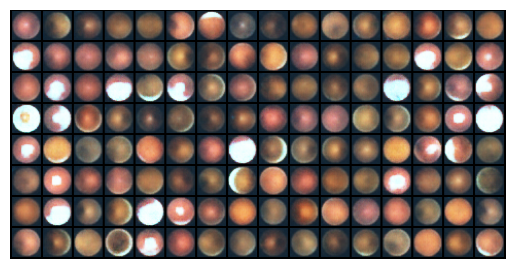

In [44]:
X, _ = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, _, _ = vae(X.clone(), explicit=True)

plt.imshow(make_grid(X_hat, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

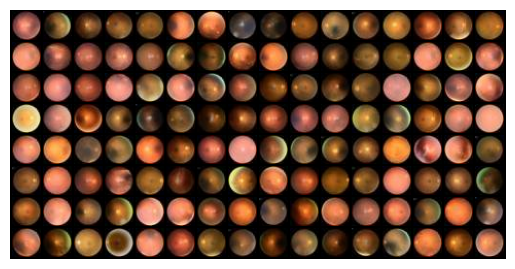

In [45]:
plt.imshow(make_grid(X, nrow=16).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

In [46]:
mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for _ in tqdm(range(1)):
        for X, label in train_loader:
            # X = transform(X)
            X, label = X.to(device), label.to(device)

            _, latent_params = vae(X)
            mu_cs.append(latent_params['mu_c'])
            mu_ss.append(latent_params['mu_s'])
            labels.append(label)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


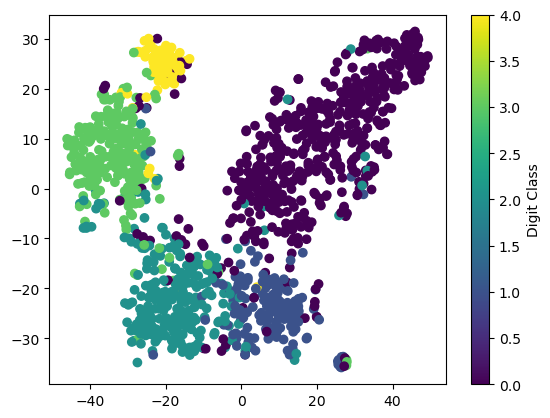

In [47]:
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [48]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

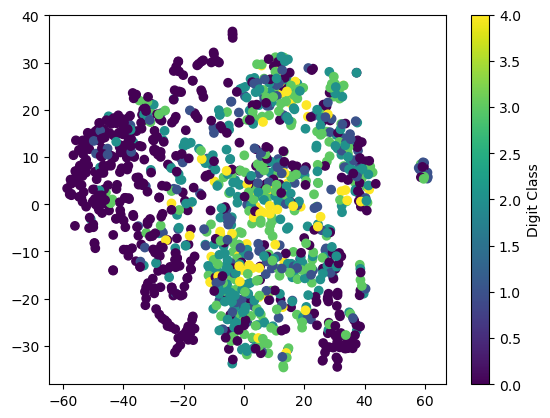

In [49]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=1, 
            c=labels.cpu().numpy(), cmap='viridis')
plt.colorbar(label='Digit Class')

In [25]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [32]:
from src.trainer import DownstreamMLPTrainer
mlp = torch.nn.Sequential(
    torch.nn.Linear(int(Z_DIM / 2), 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 5),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = DownstreamMLPTrainer(vae, mlp, optimizer, criterion, 20, device, transform)
trainer.fit(301, train_loader, test_loader)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 133.69it/s]


val_aupr: {0: 0.537, 1: 0.073, 2: 0.243, 3: 0.333, 4: 0.05}
0.247
val_auroc: {0: 0.579, 1: 0.413, 2: 0.552, 3: 0.741, 4: 0.406}
0.538


val-epoch 20: 100%|██████████| 4/4 [00:00<00:00, 148.64it/s]


val_aupr: {0: 0.83, 1: 0.149, 2: 0.312, 3: 0.439, 4: 0.109}
0.368
val_auroc: {0: 0.821, 1: 0.659, 2: 0.68, 3: 0.778, 4: 0.698}
0.727


val-epoch 40: 100%|██████████| 4/4 [00:00<00:00, 151.35it/s]


val_aupr: {0: 0.834, 1: 0.16, 2: 0.323, 3: 0.434, 4: 0.122}
0.375
val_auroc: {0: 0.817, 1: 0.67, 2: 0.688, 3: 0.78, 4: 0.726}
0.736


val-epoch 60: 100%|██████████| 4/4 [00:00<00:00, 156.69it/s]


val_aupr: {0: 0.838, 1: 0.16, 2: 0.331, 3: 0.436, 4: 0.122}
0.377
val_auroc: {0: 0.821, 1: 0.675, 2: 0.69, 3: 0.782, 4: 0.727}
0.739


val-epoch 80: 100%|██████████| 4/4 [00:00<00:00, 154.26it/s]


val_aupr: {0: 0.841, 1: 0.16, 2: 0.337, 3: 0.439, 4: 0.121}
0.38
val_auroc: {0: 0.823, 1: 0.679, 2: 0.69, 3: 0.782, 4: 0.726}
0.74


val-epoch 100: 100%|██████████| 4/4 [00:00<00:00, 148.93it/s]


val_aupr: {0: 0.844, 1: 0.159, 2: 0.339, 3: 0.439, 4: 0.12}
0.38
val_auroc: {0: 0.828, 1: 0.681, 2: 0.689, 3: 0.781, 4: 0.724}
0.741


val-epoch 120: 100%|██████████| 4/4 [00:00<00:00, 148.78it/s]


val_aupr: {0: 0.847, 1: 0.162, 2: 0.338, 3: 0.445, 4: 0.121}
0.383
val_auroc: {0: 0.834, 1: 0.685, 2: 0.687, 3: 0.782, 4: 0.722}
0.742


val-epoch 140: 100%|██████████| 4/4 [00:00<00:00, 153.24it/s]


val_aupr: {0: 0.849, 1: 0.164, 2: 0.332, 3: 0.444, 4: 0.121}
0.382
val_auroc: {0: 0.835, 1: 0.687, 2: 0.689, 3: 0.781, 4: 0.721}
0.743


val-epoch 160: 100%|██████████| 4/4 [00:00<00:00, 151.14it/s]


val_aupr: {0: 0.849, 1: 0.166, 2: 0.332, 3: 0.444, 4: 0.121}
0.382
val_auroc: {0: 0.835, 1: 0.688, 2: 0.689, 3: 0.78, 4: 0.719}
0.742


val-epoch 180: 100%|██████████| 4/4 [00:00<00:00, 137.40it/s]


val_aupr: {0: 0.848, 1: 0.166, 2: 0.334, 3: 0.444, 4: 0.12}
0.382
val_auroc: {0: 0.835, 1: 0.69, 2: 0.687, 3: 0.781, 4: 0.717}
0.742


val-epoch 200: 100%|██████████| 4/4 [00:00<00:00, 155.70it/s]


val_aupr: {0: 0.848, 1: 0.167, 2: 0.334, 3: 0.444, 4: 0.12}
0.383
val_auroc: {0: 0.835, 1: 0.692, 2: 0.686, 3: 0.782, 4: 0.717}
0.742


val-epoch 220: 100%|██████████| 4/4 [00:00<00:00, 137.75it/s]


val_aupr: {0: 0.851, 1: 0.176, 2: 0.334, 3: 0.442, 4: 0.119}
0.384
val_auroc: {0: 0.838, 1: 0.693, 2: 0.686, 3: 0.781, 4: 0.716}
0.743


val-epoch 240: 100%|██████████| 4/4 [00:00<00:00, 140.52it/s]


val_aupr: {0: 0.85, 1: 0.175, 2: 0.331, 3: 0.441, 4: 0.119}
0.383
val_auroc: {0: 0.836, 1: 0.695, 2: 0.685, 3: 0.781, 4: 0.715}
0.742


val-epoch 260: 100%|██████████| 4/4 [00:00<00:00, 150.80it/s]


val_aupr: {0: 0.851, 1: 0.174, 2: 0.326, 3: 0.437, 4: 0.119}
0.381
val_auroc: {0: 0.837, 1: 0.694, 2: 0.685, 3: 0.781, 4: 0.715}
0.742


val-epoch 280: 100%|██████████| 4/4 [00:00<00:00, 155.18it/s]


val_aupr: {0: 0.85, 1: 0.174, 2: 0.326, 3: 0.437, 4: 0.119}
0.381
val_auroc: {0: 0.836, 1: 0.695, 2: 0.685, 3: 0.78, 4: 0.715}
0.742


val-epoch 300: 100%|██████████| 4/4 [00:00<00:00, 135.54it/s]

val_aupr: {0: 0.852, 1: 0.175, 2: 0.323, 3: 0.436, 4: 0.12}
0.381
val_auroc: {0: 0.838, 1: 0.695, 2: 0.684, 3: 0.78, 4: 0.715}
0.742


In [29]:
trainer._valid(test_loader, True, 0)

val-epoch 0: 100%|██████████| 4/4 [00:00<00:00, 155.19it/s]

val_aupr: {0: 0.848, 1: 0.158, 2: 0.339, 3: 0.455, 4: 0.115}
0.383
val_auroc: {0: 0.831, 1: 0.683, 2: 0.69, 3: 0.78, 4: 0.718}
0.74
